In [1]:
import geopandas as gpd
import pandas as pd
import numpy as np
import ast
import matplotlib.pyplot as plt
import math
from fileinput import FileInput 

In [ ]:
###############################################################################################################################################################################
############                                                             Create shp file of a scenario                                                   ######################
###############################################################################################################################################################################

In [2]:
#name of the scenario's file 
file = "latenessSet1to110&3to60"

In [3]:
#If the scenario is new, reformat the output of the simulation to a readable CSV fo pandas
with FileInput("../SimResult/"+file+".csv", inplace=True) as f: 
  
        # Iterating over every and changing
        # the search_text with replace_text
        # using the replace function
        for line in f:
            line = line.replace("file_list.header","")
            line = line.replace("],[","\n")
            line = line.replace("]","")
            line = line.replace("[","")
            print(line,end='')

In [7]:
#Read the Scénario csv file and road's shapefile
road = gpd.read_file("../../includes/roads/basicScenario/roadImportance4/roads.shp")
gama_file = pd.read_csv("../SimResult/"+file+".csv")

In [9]:
#Group scenario output by road
gama_file['late max'] = gama_file['lateness']
gama_file['late mean'] = gama_file['lateness']
traited_file = gama_file.groupby(['TopoId'],group_keys=True).agg({
                                        "distance": lambda x: list(np.unique(x))[0],\
                                        "duration": lambda x: np.mean(x),\
                                        "mean speed":lambda x: np.mean(x),\
                                        "late max" : lambda x: np.max(x),\
                                        "late mean": lambda x: np.mean(x),\
                                        "ID" : lambda x:len(list(x))
                                    })
traited_file = traited_file.reset_index()
traited_file['TopoId'] = traited_file['TopoId'].map(lambda x : (x.replace("'","")))
traited_file = traited_file.rename(columns ={"ID":"frequentation"})
traited_file
#gama_file.to_csv("C:/Users/flavi/Travail/Switch-23/models/logs_file/meanMap.csv")

,TopoId,distance,duration,mean speed,late max,late mean,frequentation
0,TRONROUT0000000073456159,7,1.000000,27.000000,0,0.000000,322
1,TRONROUT0000000073456162,15,1.000000,54.000000,0,0.000000,536
2,TRONROUT0000000073456164,30,2.000000,54.000000,0,0.000000,339
3,TRONROUT0000000073456167,13,1.004773,47.904535,2,0.004773,838
4,TRONROUT0000000073456168,129,8.061972,57.630986,3,0.061972,710
...,...,...,...,...,...,...,...
8167,TRONROUT0000002330723029,149,9.000221,59.998673,1,0.000221,4522
8168,TRONROUT0000002330723030,176,11.000000,58.000000,0,0.000000,3053
8169,TRONROUT0000002330723032,13,1.000000,46.000000,0,0.000000,4997
8170,TRONROUT0000002330723033,25,2.002724,45.967728,2,0.002724,4772


In [10]:
#merge csv with shp to locate datas on topographique database
roadMean = traited_file.merge(road, left_on='TopoId', right_on='ID')

In [11]:
#convert CSV in shp
roadMean = gpd.GeoDataFrame(roadMean)

In [12]:
#save the shapefile in OUT folder
roadMean.to_file("../OUT/"+file+".shp")
roadMean

C:\Users\flavi\AppData\Local\Temp\ipykernel_19220\2194668940.py:1: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  roadMean.to_file("../OUT/"+file+".shp")


In [ ]:
###############################################################################################################################################################################
############                                                             Create a heat map of a scenario                                                 ######################
###############################################################################################################################################################################

In [ ]:
file = ""

In [34]:
#Read a scenario

#roadMean = gpd.read_file("../OUT/"+file+".shp")                #For a new scenario
roadMean = gpd.read_file("../Map/shapefiles/"+file+".shp")      #For archived scenario
roadMean

Text(0.5, 1.0, 'roads duration (109440 individu, road importance 4)')

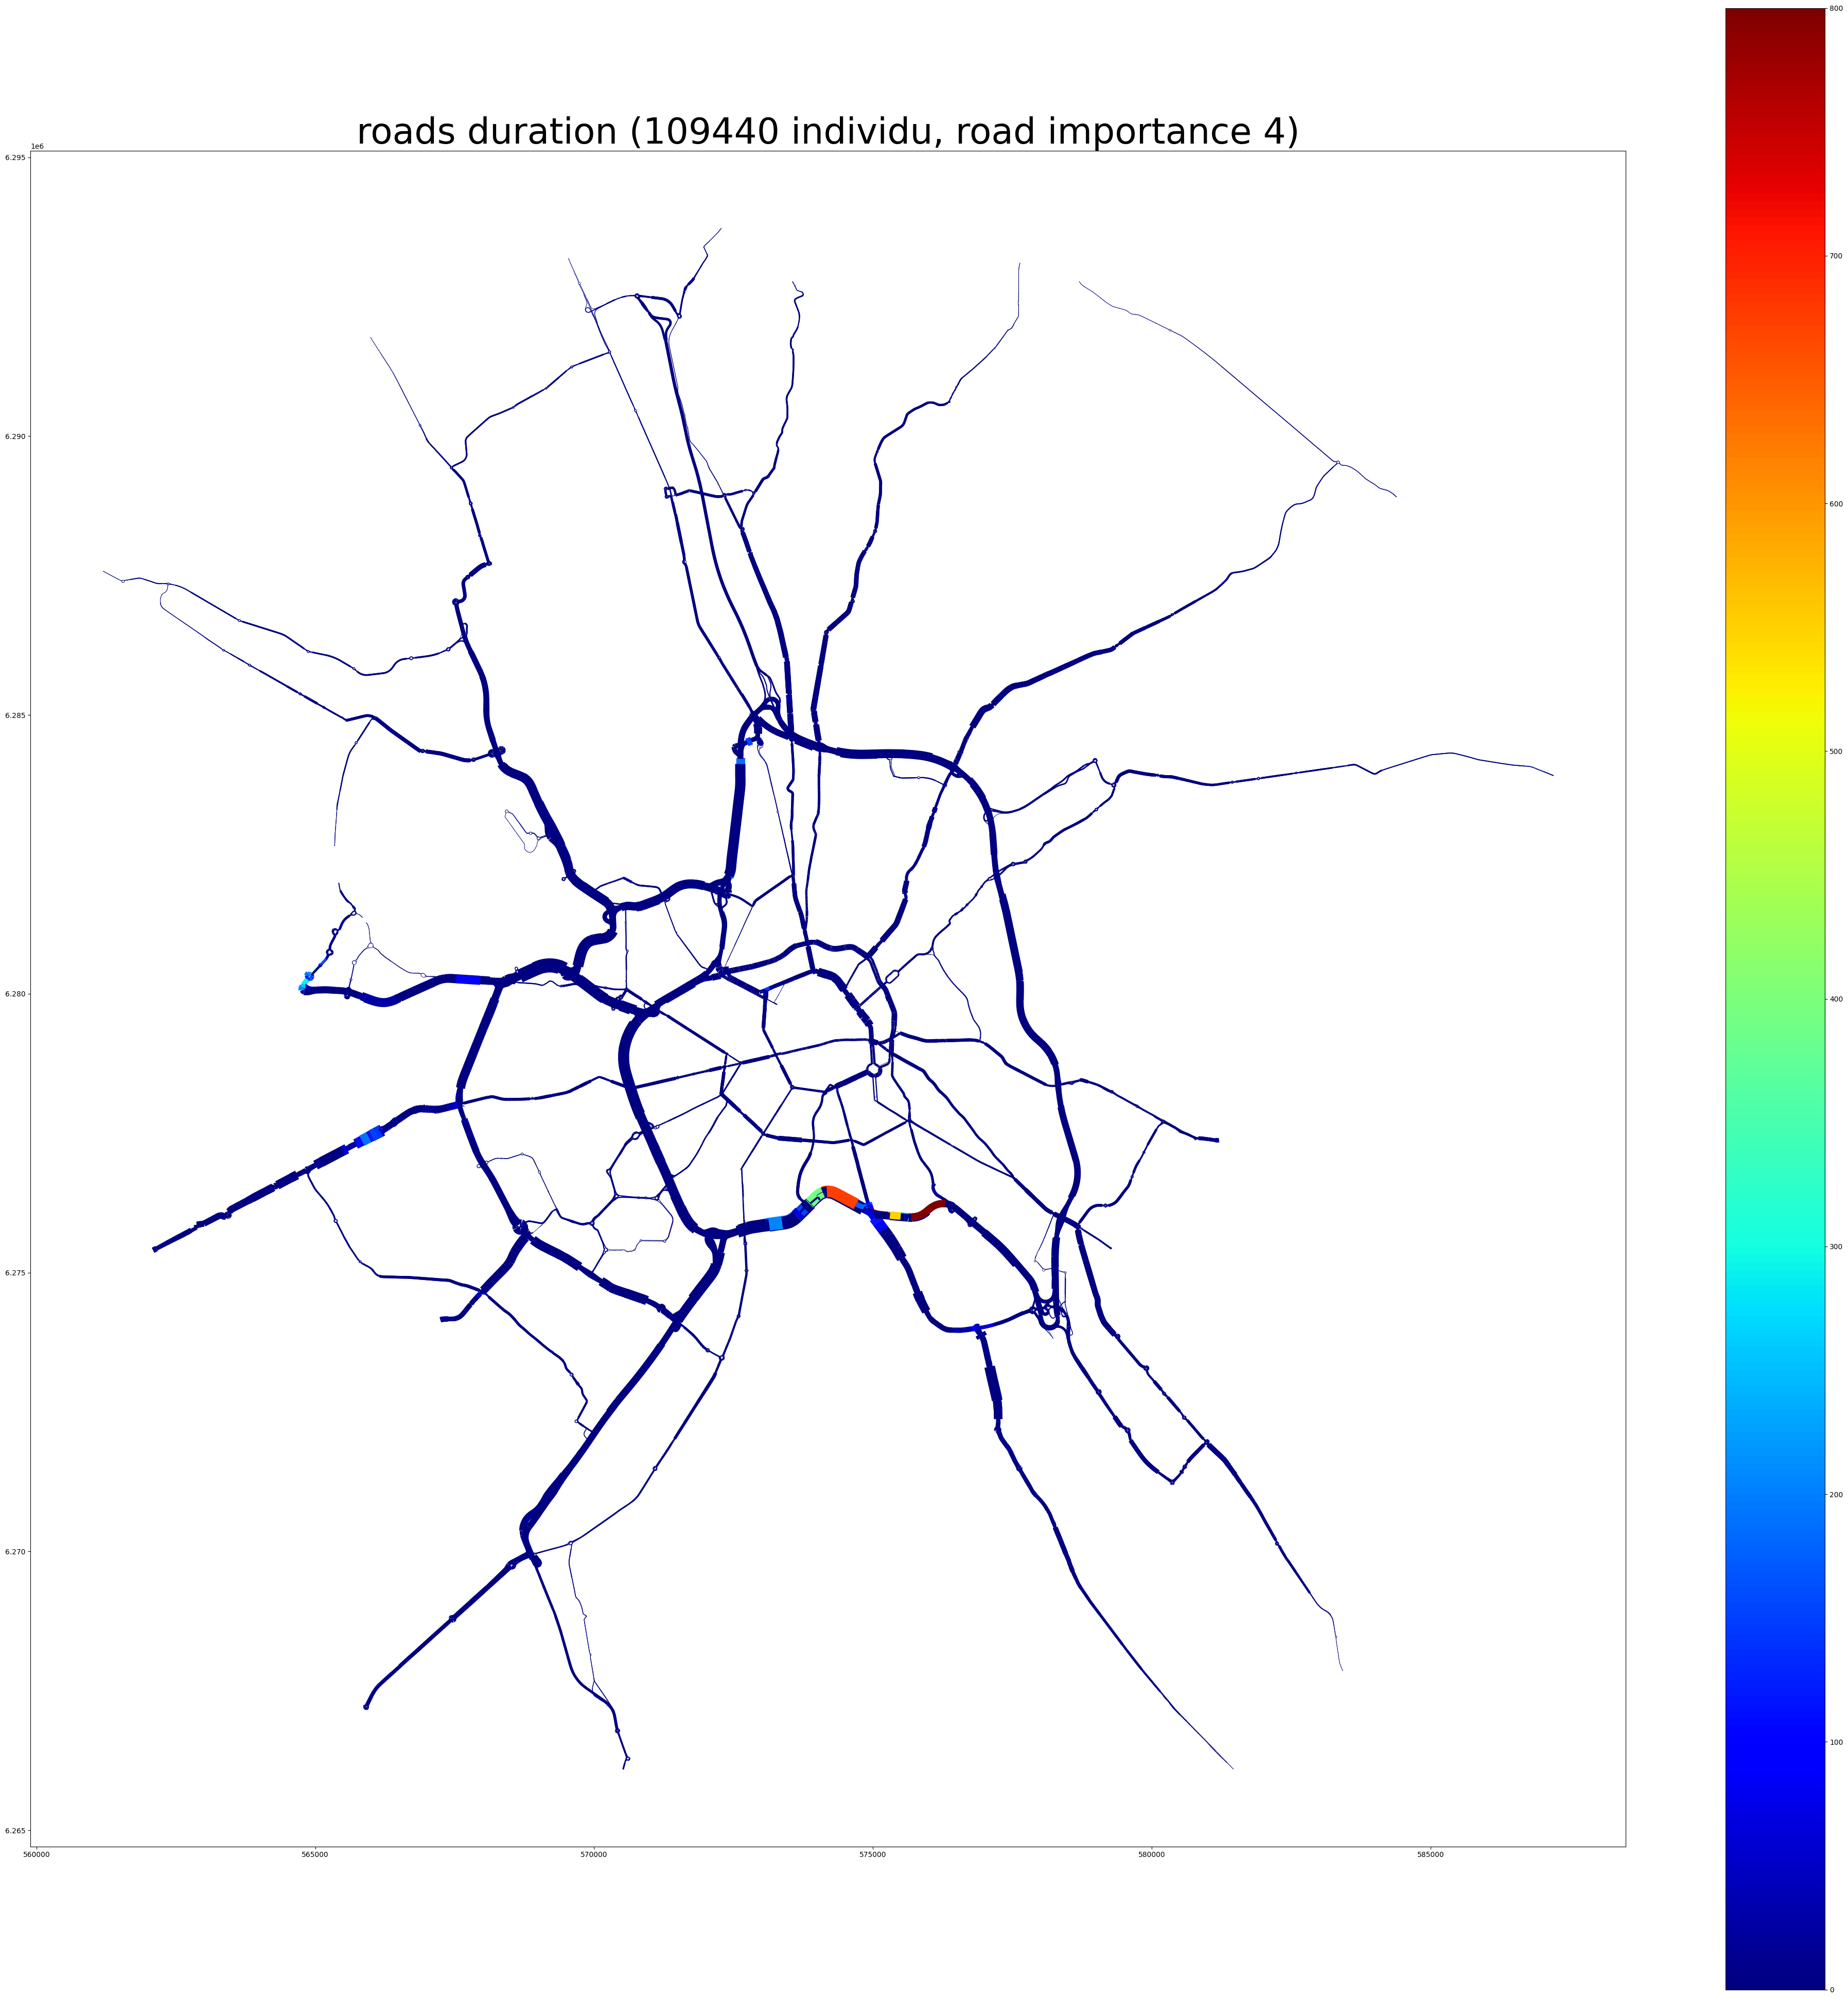

In [47]:
#print a heat map

heatMeasure = "late max"        #Data you want to use for the heat color of the map
SizeMeasure = "frequentat"      #Data you want to use for the size of the road in the map



heatmap = roadMean.plot(figsize = (50,50), column=(roadMean[heatMeasure]),vmin=0, vmax=800, legend=True, cmap='jet', linewidth=0.5+roadMean[SizeMeasure]/2000)
heatmap.set_title("roads duration (109440 individu, road importance 4)",size='50')

In [ ]:
###############################################################################################################################################################################
####################################                                    box-plot to compare scenario                                    #######################################
###############################################################################################################################################################################

In [13]:
#Define the scenario you want to compare
ComparedFile1 = "latenessBase"
comparedFile2 = "latenessSet1to90&3to30"

<Axes: >

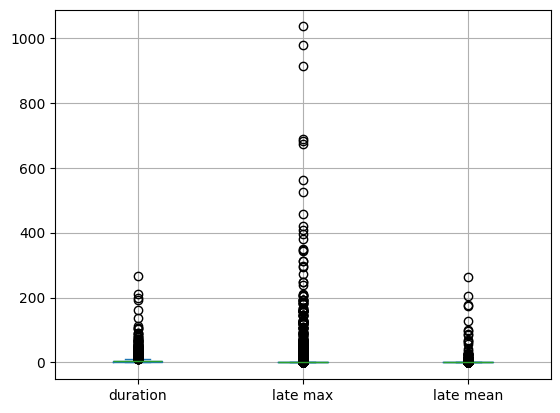

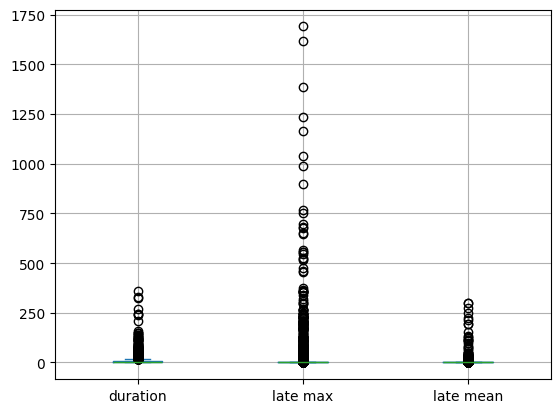

In [15]:
#plot boxplot
ComparedMap1 = gpd.read_file("../Map/shapefiles/"+ComparedFile1+".shp")
comparedMap2 = gpd.read_file("../Map/shapefiles/"+comparedFile2+".shp")
ComparedMap1.plot.box(column=['duration','late max','late mean'],logy=False,grid=True)
comparedMap2.plot.box(column=['duration','late max','late mean'],logy=False,grid=True)

In [ ]:
###############################################################################################################################################################################
###########################                                             Compare 2 scenarios with a heatmap                                          ###########################
###############################################################################################################################################################################

In [16]:
file1 = "latenessBase"
file2 = "latenessSet1to110&3to60"

In [17]:
Scenario1 = gpd.read_file("../Map/shapefiles/"+file1+".shp")
Scenario2 = gpd.read_file("../Map/shapefiles/"+file2+".shp")

In [18]:
#align both map (delet unused road if exist in one of the scenrios)

def align_dataframes_by_topoid(df1, df2):
    # Vérifier si les colonnes "TopoId" existent dans les deux DataFrames
    if "TopoId" in df1.columns and "TopoId" in df2.columns:
        # Créer un ensemble des TopoId présents dans chaque DataFrame
        topo_ids_df1 = set(df1["TopoId"])
        topo_ids_df2 = set(df2["TopoId"])

        # Identifier les TopoId présents dans les deux DataFrames
        common_topo_ids = topo_ids_df1.intersection(topo_ids_df2)

        # Filtrer les lignes qui ne sont pas présentes dans les deux DataFrames
        df1 = df1[df1["TopoId"].isin(common_topo_ids)]
        df2 = df2[df2["TopoId"].isin(common_topo_ids)]

        return df1, df2
    else:
        print("Erreur: La colonne 'TopoId' est manquante dans au moins l'un des DataFrames.")
        return None, None

# Utilisation de la fonction align_dataframes_by_topoid avec vos DataFrames comparedScenario et baseScenario
Scenario2, Scenario1 = align_dataframes_by_topoid(Scenario2, Scenario1)
Scenario2 = Scenario2.reset_index()
Scenario1 = Scenario1.reset_index()

Text(0.5, 1.0, 'diff between TT scenario and base scenario')

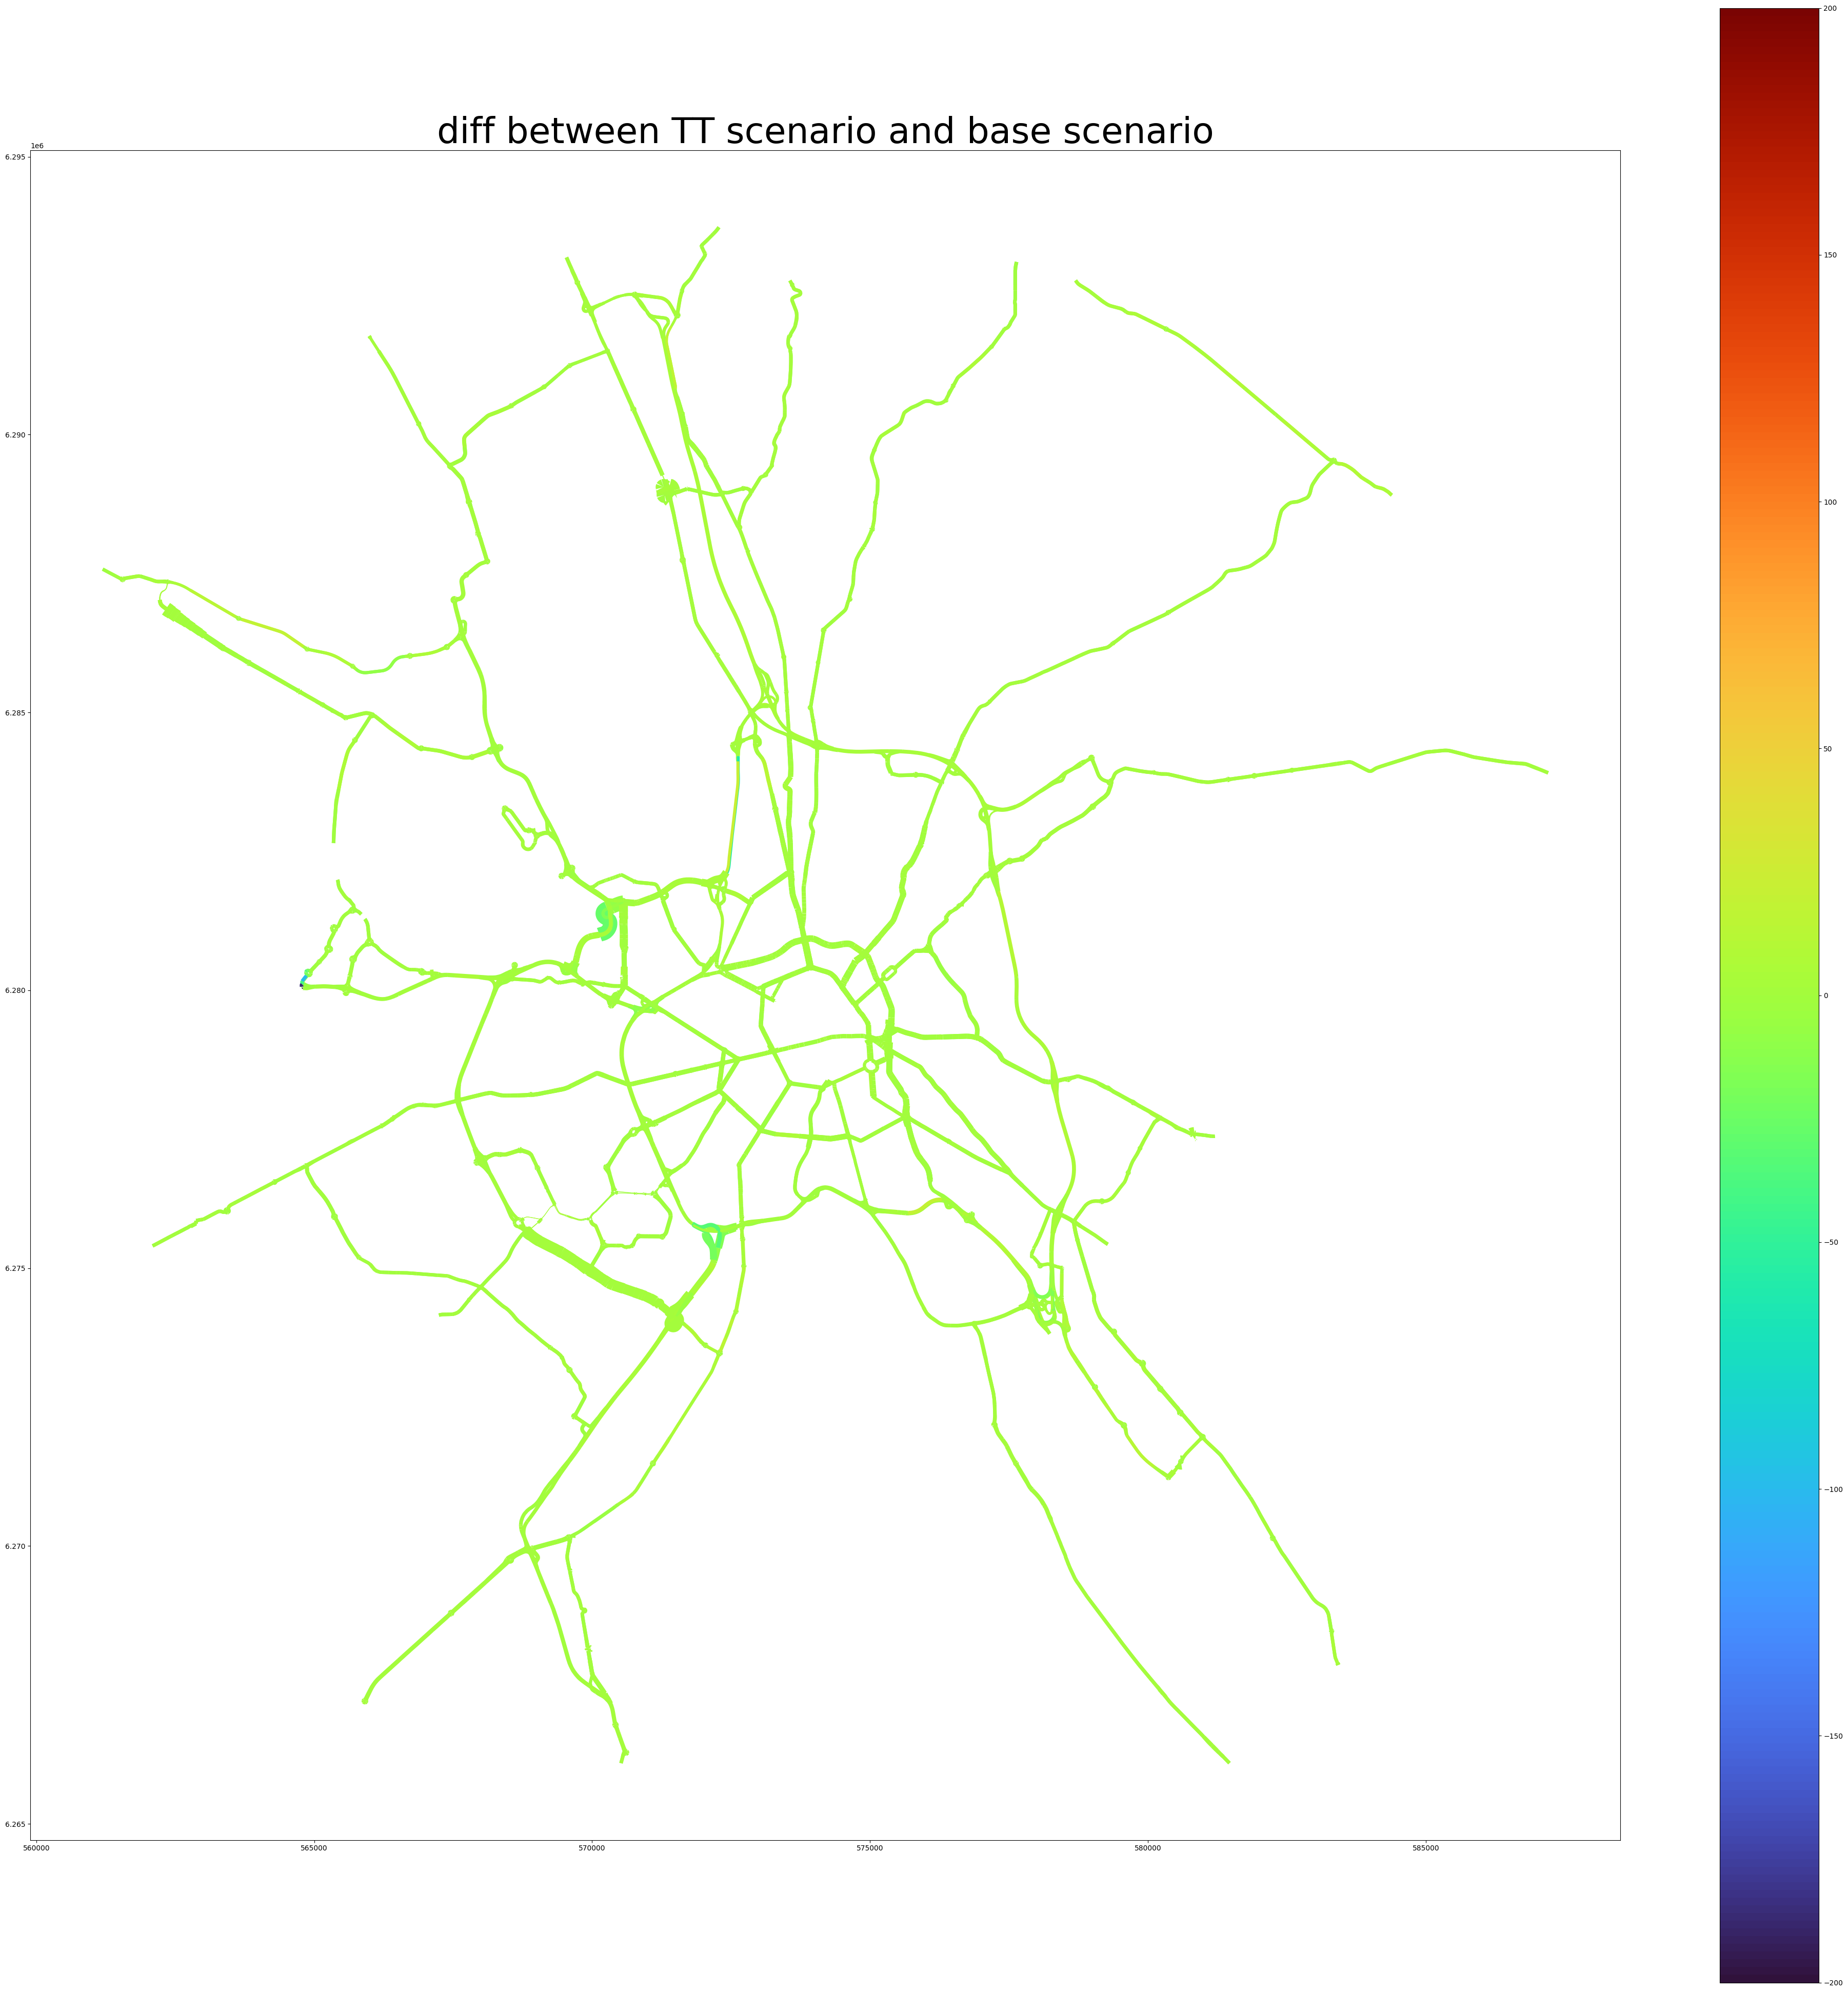

In [19]:
heatMeasure = "late max"        #Data you want to use for the heat color of the map
SizeMeasure = "frequentat"      #Data you want to use for the size of the road in the map

heatmap = Scenario2.plot(figsize = (50,50), column=(Scenario2[heatMeasure]-Scenario1[heatMeasure]),vmin=-200, vmax=200, legend=True, cmap='turbo', linewidth=(5/(Scenario1[SizeMeasure]/Scenario2[SizeMeasure])).map(lambda x : 20 if x>20 else x))
heatmap.set_title("diff "+file1+" scenario and "+file2,size='50')